# Lab 03. Build Retrival Augmented Generation System using Amazon EMR Spark Distributed Processing and OpeSearch Vector Database 

In this notebook we demonstrate how you can build a Retrival Augmented Generation System using the following components,
1. Embedding Model: `all-MiniLM-L6-v2`
2. Text Generation Model: `meta-/llama2-7b-chat`
3. Vector Database: OpenSearch as Vector Database to store embeddings
4. StreamLit UI: A Chat Interface to talk to your documents

<div style="background-color: #FFDDDD; border-left: 5px solid red; padding: 10px; color: black;">
    <strong>Kernel:</strong> Spark Analytics 2.0 [SparkMagic PySpark] <strong>Instance Type:</strong> ml.t3.medium
</div>

## Connect to an Existing EMR Cluster

In [42]:
%load_ext sagemaker_studio_analytics_extension.magics

In [43]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.
send_to_spark,%%send_to_spark -i variable -t str -n var,"Sends a variable from local output to spark cluster. Parameters: -i VAR_NAME: Local Pandas DataFrame(or String) of name VAR_NAME will be available in the %%spark context as a Spark dataframe(or String) with the same name. -t TYPE: Specifies the type of variable passed as -i. Available options are: `str` for string and `df` for Pandas DataFrame. Optional, defaults to `str`. -n NAME: Custom name of variable passed as -i. Optional, defaults to -i variable name. -m MAXROWS: Maximum amount of Pandas rows that will be sent to Spark. Defaults to 2500."
pretty,%%pretty,"If the cell output is a dataframe, like df.show(), then it will pretty print the dataframe as an HTML table"


In [44]:
%%local
!echo "Your EMR Cluster ID ---> $(aws emr list-clusters | jq '.Clusters[0].Id')"

Your EMR Cluster ID ---> "j-1X3NLYY9GGED1"


In [45]:
%sm_analytics emr connect --verify-certificate False --cluster-id j-1X3NLYY9GGED1 --auth-type None --language python  

Successfully read emr cluster(j-1X3NLYY9GGED1) details
Initiating EMR connection..
Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1698947737982_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.
{"namespace": "sagemaker-analytics", "cluster_id": "j-1X3NLYY9GGED1", "error_message": null, "success": true, "service": "emr", "operation": "connect"}


## Upload Files from Local to S3

In [6]:
%%local
!python3 -m pip install setuptools


[notice] A new release of pip available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
%%local
!python3 -m pip install sagemaker==2.192.0


[notice] A new release of pip available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [37]:
%%local
import os
import json
import glob
import boto3
import sagemaker
from tqdm import tqdm

In [115]:
%%local
REGION = "us-west-2"
sess = sagemaker.Session()
default_bucket = sess.default_bucket()
s3_client = boto3.client("s3")
print(f"Using default bucket ---> {default_bucket}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Using default bucket ---> sagemaker-us-west-2-476113589923


A few sample files are available in directory under ./AWSGuides/, these are sample documents we'll be using to build our RAG application.

In [39]:
%%local
def upload_raw_pdf_files_to_bucket(destination_bucket, destination_prefix, raw_pdf_files):
    
    print(f"Uploading ---> {len(raw_pdf_files)} files!")
    
    uploaded_file_s3uris = []
    for pdf_file in tqdm(raw_pdf_files, total=len(raw_pdf_files)):
        pdf_fname = os.path.basename(pdf_file).replace(",", "").replace(" ", "-")
        
        pdf_dest_prefix = os.path.join(destination_prefix, pdf_fname)
        
        s3_client.upload_file(
            pdf_file, 
            destination_bucket, 
            pdf_dest_prefix
        )
        uploaded_file_s3uris.append(f"s3://{destination_bucket}/{pdf_dest_prefix}")
    
    return uploaded_file_s3uris

pdf_files_to_upload = glob.glob("./AWSGuides/*.pdf")

destination_prefix = "Lab03/raw-pdfs"

files_paths_in_s3 = upload_raw_pdf_files_to_bucket(
    destination_bucket=default_bucket, 
    destination_prefix=destination_prefix,
    raw_pdf_files=pdf_files_to_upload
)

print(f"Uploaded files to ---> {files_paths_in_s3}")

Uploading ---> 3 files!


100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

Uploaded files to ---> ['s3://sagemaker-us-west-2-476113589923/Lab03/raw-pdfs/S3DeveloperGuide.pdf', 's3://sagemaker-us-west-2-476113589923/Lab03/raw-pdfs/AmazonSageMakerDeveloperGuide.pdf', 's3://sagemaker-us-west-2-476113589923/Lab03/raw-pdfs/EC2DeveloperGuide.pdf']


Let's send these variables from our local instance to Pyspark Primary node using a simple 

`%%send_to_spark` command

In [116]:
%%send_to_spark -i REGION -t str -n REGION

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'REGION' as 'REGION' to Spark kernel

In [46]:
%%send_to_spark -i destination_prefix -t str -n SRC_FILE_PREFIX

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'destination_prefix' as 'SRC_FILE_PREFIX' to Spark kernel

In [47]:
%%send_to_spark -i default_bucket -t str -n SRC_BUCKET_NAME

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'default_bucket' as 'SRC_BUCKET_NAME' to Spark kernel

## Lets Convert PDF into Text

In [86]:
import os
import boto3
import json
from PyPDF2 import PdfReader
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader
import io

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [87]:
print(f"Source bucket and prefix to read pdf files ---> {SRC_BUCKET_NAME} {SRC_FILE_PREFIX}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Source bucket and prefix to read pdf files ---> sagemaker-us-west-2-476113589923 Lab03/raw-pdfs

In [88]:
def list_files_in_s3_bucket_prefix(bucket_name, prefix):
    
    s3 = boto3.client('s3')

    # Paginate through the objects in the specified bucket and prefix, and collect all keys (file paths)
    paginator = s3.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

    file_paths = []
    for page in page_iterator:
        if "Contents" in page:
            for obj in page["Contents"]:
                if os.path.basename(obj["Key"]):
                    file_paths.append(obj["Key"])

    return file_paths

all_pdf_files = list_files_in_s3_bucket_prefix(
    bucket_name=SRC_BUCKET_NAME, 
    prefix=SRC_FILE_PREFIX
)
print(f"Found {len(all_pdf_files)} files ---> {all_pdf_files}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Found 3 files ---> ['Lab03/raw-pdfs/AmazonSageMakerDeveloperGuide.pdf', 'Lab03/raw-pdfs/EC2DeveloperGuide.pdf', 'Lab03/raw-pdfs/S3DeveloperGuide.pdf']

Let's prep a list to process files along with bucket names 

In [89]:
all_pdf_files = [(SRC_BUCKET_NAME, fpath) for fpath in all_pdf_files]
type(all_pdf_files)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'list'>

Let's convert our list to a spark RDD for parallelization of our list

In [90]:
pdfs_rdd = spark.sparkContext.parallelize(all_pdf_files)
type(pdfs_rdd)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.rdd.RDD'>

Each code node reaches out a pdf file from our list, downloads the pdf file into memory and returns a PyPDF2 class reference for downstream workloads

![EMR Read PDFs into Memory](./media/EMR-Doc-Read.jpg)

In [91]:
def load_pdf_from_s3_into_memory(row):
    """
    Load a PDF file from an S3 bucket directly into memory.
    """
    try:
        src_bucket_name, src_file_key = row 
        s3 = boto3.client('s3')
        pdf_file = io.BytesIO()
        s3.download_fileobj(src_bucket_name, src_file_key, pdf_file)
        pdf_file.seek(0)
        pdf_reader = PdfReader(pdf_file)
        return (src_file_key, pdf_reader, len(pdf_reader.pages))
    
    except Exception as e:    
        return (os.path.basename(src_file_key), str(e))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's concurrently load pdf files into memory using rdd map and collect the results back to our Primary Node

In [92]:
pdfs_in_memory = pdfs_rdd.map(load_pdf_from_s3_into_memory).collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

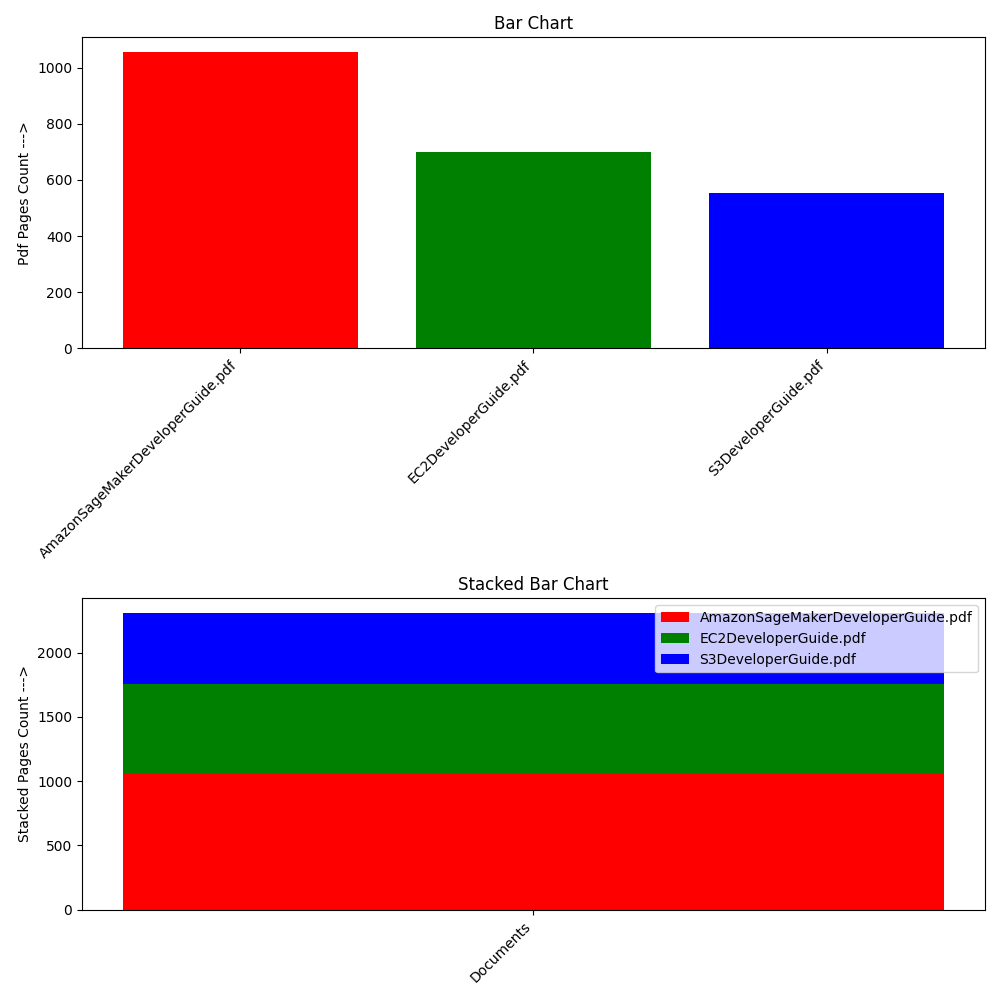

In [94]:
import numpy as np
import matplotlib.pyplot as plt

x_labels = [pdfx.split('/')[-1] for pdfx, _, _ in pdfs_in_memory]
y_values = [pages_count for _, _, pages_count in pdfs_in_memory]
x = range(len(y_values))

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# First Subplot: Bar Chart
axs[0].bar(x, y_values, color=['red', 'green', 'blue'])
axs[0].set_title('Bar Chart')
axs[0].set_xticks(x)
axs[0].set_xticklabels(x_labels, rotation=45, ha="right")
axs[0].set_ylabel('Pdf Pages Count --->')

_bottom = 0
for (pdf_name, page_count, color) in zip(x_labels, y_values, ['red', 'green', 'blue']):
    axs[1].bar([0], [page_count], bottom=_bottom, color=color, label=pdf_name)
    _bottom += page_count
axs[1].set_title('Stacked Bar Chart')
axs[1].set_xticks([0])
axs[1].set_xticklabels(['Documents'], rotation=45, ha="right")
axs[1].set_ylabel('Stacked Pages Count --->')

# Add a legend to the second subplot
axs[1].legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

%matplot plt

In [95]:
class CustomDocument:
    def __init__(self, text, path, number):
        self.page_content = text
        self.metadata = {
            'source': path, 
            'page': number  
        }

    def __repr__(self):
        # This method is for representing the object in a way that’s clear to a human (also can be used for debugging)
        return f"Document(page_content='{self.page_content}', metadata={self.metadata})"

    # Optionally, if you need a string representation of the instance that is more user-friendly, 
    # you can implement the __str__ method
    def __str__(self):
        return f"Page Content: {self.page_content}\nSource: {self.metadata['source']}\nPage Number: {self.metadata['page']}"
    
def extract_text_from_pdf_reader(row):
    """ 
    Extract text from a page of the document 
    """
    try:
        doc_path, page_num = row
        page_text = global_pdfs_in_mem_dict[doc_path].pages[page_num].extract_text()
        return page_text, doc_path, page_num
    except Exception as e:
        return str(e), doc_path, page_num

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [96]:
global_pdfs_in_mem_dict = {_key: pdf_reader for _key, pdf_reader, _ in pdfs_in_memory}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [97]:
docs_instances = []
for (file_src, _, page_count) in pdfs_in_memory:
    for pg_num in range(page_count):
        docs_instances.append((file_src, pg_num))
print(f"Created {len(docs_instances)} parallel instances to process!")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Created 2306 parallel instances to process!

In [98]:
docs_instances_rdd = spark.sparkContext.parallelize(docs_instances)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Every PDF document has 'n' pages to process, this task can be executed in a parallel fashion using Spark Processing. 

Each Document is split page by page, each page from a global reference of in memory pdfs.

![PageLevelProcessingEMRPDFtoTxt](./media/PageLevelProcessingEMRPDFtoTxt.jpg)

In [99]:
documents = docs_instances_rdd.map(extract_text_from_pdf_reader).collect()
documents_custom = [
    CustomDocument(text=text, path=doc_source, number=page_num) 
    for text, doc_source, page_num in documents
]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [101]:
documents_custom[121]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Document(page_content='Amazon SageMaker Developer Guide
Image Classiﬁcation Algorithm
ResourceConﬁg (p. 667)
The resources, including the ML compute instances and ML storage volumes, to use for
model training.
ML storage volumes store model artifacts and incremental states. Training algorithms
might also use ML storage volumes for scratch space. If you want Amazon SageMaker
to use the ML storage volume to store the training data, choose File  as the
TrainingInputMode  in the algorithm speciﬁcation. For distributed training algorithms,
specify an instance count greater than 1.
Type: ResourceConﬁg (p. 991) object
Required: Yes
RoleArn (p. 667)
The Amazon Resource Name (ARN) of an IAM role that Amazon SageMaker can assume to
perform tasks on your behalf.
During model training, Amazon SageMaker needs your permission to read input data
from an S3 bucket, download a Docker image that contains training code, write model
artifacts to an S3 bucket, write logs to Amazon CloudWatch Logs, and publ

We split pages using a reference chunk size, chunk size is an experimental value. To learn more about chunk size and how RecursiveCharacterTextSplitter, see: https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/recursive_text_splitter

In [102]:
global_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=750,
    chunk_overlap=10
)
docs = global_text_splitter.split_documents(documents_custom)
print(f"Total number of docs pre-split {len(documents_custom)} | after split {len(docs)}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total number of docs pre-split 2306 | after split 7732

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

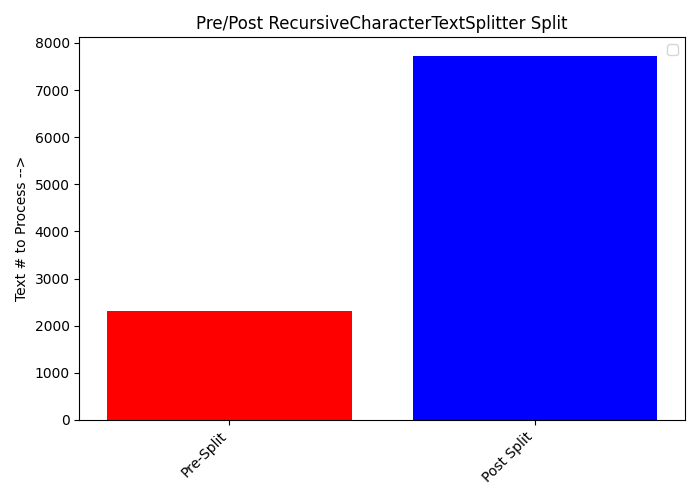

In [112]:
# create data
plt.clf()

x_labels = ["Pre-Split", "Post Split"]
y = [len(documents_custom), len(docs)]
x = range(len(x_labels))

fig, axs = plt.subplots(1, 1, figsize=(7, 5))

# First Subplot: Bar Chart
axs.bar(x, y, color=["red", "blue"])
axs.set_title('Pre/Post RecursiveCharacterTextSplitter Split')
axs.set_xticks(x)
axs.set_xticklabels(x_labels, rotation=45, ha="right")
axs.set_ylabel('Text # to Process -->')

# Add a legend to the second subplot
axs.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

%matplot plt

In [114]:
print(docs[1001])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

page_content='For more information about model tuning, see Automatic Model Tuning (p. 288).\nMetrics Computed by the XGBoost Release 0.72 Algorithm\nThe XGBoost algorithm based on version 0.72 computes the following nine metrics during training.\nWhen tuning the model, choose one of these metrics as the objective to evaluate the model.\nMetric Name Description Optimization Direction\nvalidation:auc Area under the curve. Maximize\n274' metadata={'source': 'Lab03/raw-pdfs/AmazonSageMakerDeveloperGuide.pdf', 'page': 281}

## Run Parallelized Embeddings using Amazon EMR (EC2 Spark based Processing)

In [37]:
def generate_embeddings(input_text_sample):
    
    assert isinstance(input_text_sample, str), f"Input must be a single string but found " 
    
    lambda_client = boto3.client('lambda', region_name='us-west-2') 

    # Prepare the data to send to the Lambda function
    data = {
        "input": input_text_sample
    }

    # Invoke the Lambda function
    response = lambda_client.invoke(
        FunctionName="invokeEmbeddingEndpoint",
        InvocationType="RequestResponse",
        Payload=json.dumps(data)
    )

    # Decode and load the response payload
    response_payload = json.loads(response['Payload'].read().decode("utf-8"))

    # Extract status and embeddings from the response
    status_code, embeddings = int(response_payload['statusCode']), json.loads(response_payload['body'])

    return status_code, embeddings
    
class EmbeddingsGenerator:
    
    @staticmethod
    def embed_documents(input_text, normalize=True):
        """
        Generate embeddings for the provided text, invoking a Lambda function.
        """
        assert isinstance(input_text, list), "Input type must me list to embed_documents function"
        
        input_text_rdd = spark.sparkContext.parallelize(input_text)
        
        embeddings_generated = input_text_rdd.map(generate_embeddings).collect()
        
        embedding_response = []
        for s_code, embeddings in embeddings_generated:
            if s_code == 200:
                embedding_response.append(embeddings)
            else:
                pass
        
        return embedding_response
    
    @staticmethod
    def embed_query(input_text):
        status_code, embedding = generate_embeddings(input_text)
        if status_code == 200:
            return embedding
        else: 
            None

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
response_code, sample_sentence_embedding = generate_embeddings(docs[1000].page_content)
print(f"Status {response_code}, Embedding size of the document --->", len(sample_sentence_embedding))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Status 200, Embedding size of the document ---> 384

In [2]:
%%local
INDEX_NAME_OSE = "amz-guides-index"

In [40]:
%%send_to_spark -i INDEX_NAME_OSE -t str -n INDEX_NAME_OSE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'INDEX_NAME_OSE' as 'INDEX_NAME_OSE' to Spark kernel

In [117]:
%%local
def get_secret(secret_name, region_name="us-west-2"):
    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )
    get_secret_value_response = client.get_secret_value(
        SecretId=secret_name
    )
    secrets = json.loads(get_secret_value_response['SecretString'])
    user = secrets['username']
    pwd = secrets['password']
    return user, pwd

# Use the function
my_secret_name = "OpenSearchSecret-workshop-studio-cfn"  
user, pwd = get_secret(my_secret_name, REGION)
print(f"Session user and pwd ---> ", user, pwd)

Session user and pwd --->  raguser lc#a*?aUSNbj0G'ld#bQ+iEz4Wp<-lmT


In [62]:
%%send_to_spark -i user -t str -n user

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'user' as 'user' to Spark kernel

In [63]:
%%send_to_spark -i pwd -t str -n pwd

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'pwd' as 'pwd' to Spark kernel

In [47]:
import time
from langchain.vectorstores import OpenSearchVectorSearch


start = time.time()
docsearch = OpenSearchVectorSearch.from_documents(
    docs, 
    EmbeddingsGenerator, 
    opensearch_url="https://search-opensearchservi-gawzad6dgaoi-dfwotp4qzylozyn2tbqobn55tq.us-west-2.es.amazonaws.com",
    bulk_size=len(docs),
    http_auth=(user, pwd),
    index_name=INDEX_NAME_OSE,
    engine="faiss"
)

end = time.time()
print(f"Total Time for ingestion: {round(end - start, 2)} secs")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Time for ingestion: 601.89 secs

In [48]:
query = "What is a Amazon SageMaker?"
sample_responses = docsearch.similarity_search(
    query, 
    k=5, 
    space_type="cosineSimilarity", 
    search_type="painless_scripting"
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
sample_responses[4].page_content

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'Amazon SageMaker\nDeveloper Guide'

## Putting it All Together

To recap,

1. We create a Spark Cluster to leverage PySpark for Distributed Data Processing at scale!
2. We pushed some raw data into S3 (in reality, this data can be housed anywhere RedShift, S3, RDS, Dynamo, Snowflake, etc..)
3. We Parallelized our document extraction from S3 using PySpark - our PySpark `Core` nodes were able to reach out to doc store (S3) read a file into memory for downstream processing
4. We then split our processing at Document - at a page level and further parallelize our pdf reading process using PySpark
5. We chunk our document corpus using `LangChain`'s `RecursiveCharacterTextSplitter`. We then convert our text into Embeddings using `all-Mini-l6-v2` Embedding LLM Model and ingest these embeddings into OpenSearch index. - all using PySpark Parallel Processing technique
6. We then move over to a local session using `%%local`- A user asks a Question aka Query, We retrieve similar documents from OpenSearch aka Context, We feed Query + Context to a Text Generation LLM `Llama2-13b` to provide a well crafted response to a user's question

In [57]:
%%local
!python3 -m pip install -q opensearch-py==2.3.2 langchain==0.0.310 typing_extensions==4.7.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 3.3.0 which is incompatible.

[notice] A new release of pip available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


From our local session, we need to link up with our OpenSearch Cluster so we con combine a User's query with our Vector DB back and generate a response from our SageMaker Chat `Llama2-13b` endpoint

In [27]:
%%local
import boto3
from langchain.vectorstores import OpenSearchVectorSearch


class EmbeddingGenerator:
    def __init__(self):
        self.lambda_client = boto3.client('lambda', region_name='us-west-2')
    
    def embed_query(self, input_text_sample):
        """Generate embeddings for the input text."""
        
        lambda_client = boto3.client('lambda', region_name='us-west-2') 
        
        # Prepare the data to send to the Lambda function
        data = {
            "input": input_text_sample
        }

        # Invoke the Lambda function
        response = lambda_client.invoke(
            FunctionName="invokeEmbeddingEndpoint",
            InvocationType="RequestResponse",
            Payload=json.dumps(data)
        )

        # Decode and load the response payload.
        response_payload = json.loads(response['Payload'].read().decode("utf-8"))

        # Extract status and embeddings from the response.
        status_code, embeddings = int(response_payload['statusCode']), json.loads(response_payload['body'])

        return embeddings


embedding_generator = EmbeddingGenerator()

docsearch = OpenSearchVectorSearch(
    index_name=INDEX_NAME_OSE,
    embedding_function=embedding_generator,
    opensearch_url="https://search-opensearchservi-gawzad6dgaoi-dfwotp4qzylozyn2tbqobn55tq.us-west-2.es.amazonaws.com",
    http_auth=(user, pwd),
    engine="faiss"
)

In [28]:
%%local
import re
import json
from typing import Dict
from langchain.llms.sagemaker_endpoint import LLMContentHandler
from langchain.llms import SagemakerEndpoint
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import RetrievalQA


class ContentHandler(LLMContentHandler):
    
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs: Dict) -> bytes:
        
        pattern = r"(QUESTION:\n)(.*?)(\n\n)"
        
        match = re.search(pattern, prompt, re.DOTALL)
        
        # question_block = match.group(0)
        query_only = match.group(2)
        
        modified_prompt = re.sub(pattern, '', prompt, flags=re.DOTALL)
        
        body = {
            "inputs": [
                [
                     {
                         "role": "system", 
                         "content": modified_prompt
                     },
                    {
                        "role": "user", 
                        "content": query_only
                    },
                ]   
            ], 
            "parameters": model_kwargs
        }
        input_str = json.dumps(body)
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        system_response = response_json[0]['generation']['content']
        return system_response.strip()

content_handler = ContentHandler()


llm_sm_ep = SagemakerEndpoint(
    endpoint_name="meta-llama2-7b-chat-tg-ep", 
    region_name=REGION,
    model_kwargs={
        "max_new_tokens": 512, 
        "top_p": 1.0, 
        "temperature": 0.1, 
        "return_full_text": False
    },
    content_handler=content_handler,
    endpoint_kwargs={"CustomAttributes": 'accept_eula=true'}
)

In [29]:
%%local
from langchain import PromptTemplate

template = """
Answer the following QUESTION based on the CONTEXT
given. If you do not know the answer and the CONTEXT doesn't
contain the answer truthfully say "I don't know".

CONTEXT:
{context}

QUESTION:
{question}

ANSWER:
"""
prompt_template = PromptTemplate(
    template=template, 
    input_variables=['context', 'question']
)

llm_qa_smep_chain = RetrievalQA.from_chain_type(
    llm=llm_sm_ep,
    chain_type='stuff',
    retriever=docsearch.as_retriever(search_kwargs={"k": 10, "space_type": "cosineSimilarity", "space_type": "painless_scripting"}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt_template}
)


def pretty_print(chain_op):
    question = chain_op['query']
    
    response = chain_op['result']
    
    sources = "\n".join([f"-{src.metadata['source'].split('/')[-1]} (page: {src.metadata['page']})" for src in chain_op['source_documents']])
    
    stdout = f"""Question:\n> {question}\n\n================\nSystem:\n> {response}\n\n================\nSources:\n{sources}
    """
    print(stdout)

In [30]:
%%local
pretty_print(llm_qa_smep_chain("What is a SageMaker Training job and how do you run it?"))

Question:
> What is a SageMaker Training job and how do you run it?

System:
> Based on the provided context, a SageMaker Training job is an iterative process that teaches a model to make predictions by using an algorithm and example data to train a model. To run a training job in Amazon SageMaker, you can use the console, the low-level API, or the Python SDK.

Here are the general steps to run a training job:

1. Open the Amazon SageMaker console at <https://console.aws.amazon.com/sagemaker/>.
2. Choose "Algorithms" from the left navigation pane.
3. Select an algorithm that you created or subscribe to from the list on the "My Algorithms" tab or the "AWS Marketplace Subscriptions" tab.
4. Choose "Create Training Job" on the algorithm detail page.
5. Provide the following information on the "Create Training Job" page:
	* Algorithm specification
	* Training job name
	* Role for the training job (optional)
	* Hyperparameter tuning parameters (optional)
6. Choose "Create Training Job" to s

In [84]:
%%local
pretty_print(llm_qa_smep_chain("What types of GPU instance types are supported SageMaker?"))

Question:
> What types of GPU instance types are supported SageMaker?

System:
> Based on the provided context, the following GPU instance types are supported by Amazon SageMaker:

* ml.gpu.xlarge
* ml.gpu.8xlarge
* ml.gpu.16xlarge

These instance types provide on-demand GPU computing for training and hosting machine learning models.

Sources:
-AmazonSageMakerDeveloperGuide.pdf (page: 407)
-AmazonSageMakerDeveloperGuide.pdf (page: 79)
-AmazonSageMakerDeveloperGuide.pdf (page: 80)
-AmazonSageMakerDeveloperGuide.pdf (page: 331)
-AmazonSageMakerDeveloperGuide.pdf (page: 664)
-AmazonSageMakerDeveloperGuide.pdf (page: 988)
-AmazonSageMakerDeveloperGuide.pdf (page: 342)
-AmazonSageMakerDeveloperGuide.pdf (page: 335)
-AmazonSageMakerDeveloperGuide.pdf (page: 245)
-AmazonSageMakerDeveloperGuide.pdf (page: 230)
    


In [32]:
%%local
pretty_print(llm_qa_smep_chain("How to install packages on EC2 instances using Command line?"))

Question:
> How to install packages on EC2 instances using Command line?

System:
> Based on the given context, you can install packages on EC2 instances using the command line by following these steps:

1. Install the required development tools:

You can install the required development tools, such as `make`, `gcc`, and `autoconf`, using the `yum` command. For example:
```
sudo yum groupinstall "Development Tools"
```
2. Create a placement group:

You can create a placement group using the `ec2-create-placement-group` command. For example:
```
sudo ec2-create-placement-group my-placement-group
```
3. Install packages:

You can install packages in a placement group using the `yum` command. For example:
```
sudo yum install my-package
```
4. Activate a conda environment:

If you want to install packages that are available in a specific conda environment, you can activate that environment using the `source` command. For example:
```
source activate python3
```
5. Install packages:

You c

In [33]:
%%local
pretty_print(llm_qa_smep_chain("How to Create a Training Job using Boto3 SDK?"))

Question:
> How to Create a Training Job using Boto3 SDK?

System:
> Based on the provided context, the answer to your question is:

To create a training job using Boto3 SDK, you can follow these steps:

1. Import the necessary modules: `import sagemaker` and `from sagemaker.amazon.amazon_estimator import get_image_uri`
2. Get the location of the XGBoost container using `get_image_uri(boto3.Session().region_name, 'xgboost')`: This will return the URL of the XGBoost container in the specified region.
3. Set up the training information for the job using `training_job_params =...`: This involves passing the necessary information for the training job, such as the training and validation data folders, the algorithm to use, and the resource configuration.
4. Name the training job using `training_job_name =...`: This should be a unique name for the training job within the specified AWS Region.
5. Call `sm.create_training_job(**training_job_params)` to start the training job.

Note: The `sm` o

In [34]:
%%local
pretty_print(llm_qa_smep_chain("How can I deploy a model to SageMaker Hosting service?"))

Question:
> How can I deploy a model to SageMaker Hosting service?

System:
> To deploy a model to Amazon SageMaker hosting services, you can follow these steps:

1. Create a model in Amazon SageMaker by providing the location of the S3 bucket that contains your model artifacts and the registry path of the image that contains the inference code.
2. Create an endpoint configuration for an HTTPS endpoint by specifying the name of one or more models, the production variants, and the ML compute instances that you want Amazon SageMaker to launch to host each production variant.
3. Call the CreateEndpoint API to deploy the model to Amazon SageMaker hosting services.

Alternatively, you can use the AWS SDK for Python (Boto 3) to deploy a model to Amazon SageMaker hosting services. The process is similar to the above steps, but you will need to send a CreateEndpointConfig request to provide the resource configuration for hosting.

It's important to note that you can only use the CreateEndpoint

In [35]:
%%local
pretty_print(llm_qa_smep_chain("How do I validate a model using boto3 sdk and visualize results using matplotlib library?"))

Question:
> How do I validate a model using boto3 sdk and visualize results using matplotlib library?

System:
> To validate a model using the AWS SDK for Python (Boto 3) and visualize the results using the matplotlib library, you can follow these steps:

1. Download the test data from Amazon S3:
```python
s3 = boto3.resource('s3')
test_key = "{}/test/examples".format(prefix)
s3.Bucket(bucket).download_file(test_key, 'test_data')
```
2. Plot the first 10 images from the test dataset with their labels using matplotlib:
```python
%matplotlib inline
for i in range(0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28, 28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()
```
3. Get inferences from the first 10 examples in the test dataset by calling the `invoke_endpoint` method of the Amazon SageMaker runtime client:
```python
with open('test_data', 'r') as f:
    for i in range(0, 10):
      

In [36]:
%%local
pretty_print(llm_qa_smep_chain("How can I use the console to add a git repository to my SageMaker account?"))

Question:
> How can I use the console to add a git repository to my SageMaker account?

System:
> Based on the provided context, you can use the Amazon SageMaker console to add a Git repository to your SageMaker account by following these steps:

1. Open the Amazon SageMaker console at <https://console.aws.amazon.com/sagemaker/>.
2. Choose "Git repositories" from the top-level menu.
3. Click on "Add repository" in the top-right corner of the page.
4. Select "AWS CodeCommit" as the repository type, or enter the URL of a Git repository hosted elsewhere.
5. Follow the prompts to enter the repository name, Git credentials (if necessary), and other details.
6. Choose "Add repository" to complete the process.

Note that you can also use the AWS CLI to add a Git repository to your SageMaker account by running the command `aws sagemaker create-code-repository`. For more information, see the Amazon SageMaker Developer Guide.

Sources:
-AmazonSageMakerDeveloperGuide.pdf (page: 54)
-AmazonSageMak